In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
def scaling_func(D, L_inf, B, beta):
    return L_inf + B / (D ** beta)

# Loss function: Mean Squared Error
def loss_function(params, D, L_values):
    L_inf, B, beta = params
    L_pred = scaling_func(D, L_inf, B, beta)
    return np.mean((L_pred - L_values) ** 2)


In [27]:

def visualize(L_values, D_values_scaled, L_inf_fit, B_fit, beta_fit, preds=None, tokens_scaling_factor=1e8):
    # Determine the maximum D (in normalized units) from training and prediction data
    max_D_train = np.max(D_values_scaled)
    max_D_preds = max_D_train
    if preds is not None:
        preds = np.array(preds, dtype=object)  # to preserve None entries
        D_preds = preds[:, 0].astype(float)
        D_preds_norm = D_preds / tokens_scaling_factor
        max_D_preds = np.max(D_preds_norm)
    else:
        D_preds_norm = np.array([])  # empty array if preds not provided
    max_D = max(max_D_train, max_D_preds)
    
    # Generate a smooth range for visualization from min D to max_D
    D_fit = np.linspace(np.min(D_values_scaled), max_D, 100)
    D_fit = np.linspace(100,10000,100)
    L_fit = scaling_func(D_fit, L_inf_fit, B_fit, beta_fit)
    
    # Compute predicted loss for training points
    L_pred_train = scaling_func(D_values_scaled, L_inf_fit, B_fit, beta_fit)
    
    # Setup the figure with 2 subplots: left (normal), right (log-log)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # ----- Left Plot: Normal Scale -----
    ax = axs[0]
    ax.scatter(D_values_scaled, L_values, label="Training Data (Observed)", color="red", marker="o", zorder=3)
    ax.plot(D_fit, L_fit, label=f"Fitted Curve\n$L(D)= {L_inf_fit:.4f} + {B_fit:.4f} / D^{{{beta_fit:.4f}}}$", color="blue", linewidth=2)
    ax.scatter(D_values_scaled, L_pred_train, label="Training Data (Fitted)", color="green", marker="x", zorder=3)
    
    if preds is not None:
        # Process prediction data
        # D_preds_norm is already computed; now extract observed losses, if any.
        # Create a boolean mask: True if the ground truth is not None.
        observed_mask = np.array([p is not None for p in preds[:, 1]])
        
        # Compute projected loss from the curve for new predictions
        L_fitted_preds = scaling_func(D_preds_norm, L_inf_fit, B_fit, beta_fit)
        
        # Plot projected values (all new predictions)
        ax.scatter(D_preds_norm, L_fitted_preds, label="New Data (Projected)", color="black", marker="*", s=120, zorder=3)
        
        # If observed ground truth exists for any, plot them
        if np.any(observed_mask):
            L_preds_observed = np.array([float(p) for p in preds[:, 1] if p is not None])
            D_preds_norm_obs = D_preds_norm[observed_mask]
            ax.scatter(D_preds_norm_obs, L_preds_observed, label="New Data (Observed)", color="purple", marker="^", s=100, zorder=3)
        
        # Annotate all new prediction points with their projected value
        for i in range(len(D_preds_norm)):
            ax.annotate(f"Proj: {L_fitted_preds[i]:.4f}", 
                        (D_preds_norm[i], L_fitted_preds[i]), 
                        textcoords="offset points", xytext=(5, -10), ha="left", fontsize=10, color="black")
    
    ax.set_xlabel(f"Training Tokens (×{tokens_scaling_factor:.0e})")
    ax.set_ylabel("Loss")
    ax.set_title("Scaling Law Fit (Normal Scale)")
    ax.legend()
    ax.grid(True)
    
    # ----- Right Plot: Log-Log Scale -----
    ax = axs[1]
    # Plot the extended fitted curve
    ax.loglog(D_fit, L_fit, 'b-', label="Fitted Curve", linewidth=2)
    # Plot training data points
    ax.loglog(D_values_scaled, L_values, 'ro', label="Training Data (Observed)")
    ax.loglog(D_values_scaled, L_pred_train, 'gx', label="Training Data (Fitted)")
    
    if preds is not None:
        ax.loglog(D_preds_norm, L_fitted_preds, '*', label="New Data (Projected)", color="black", markersize=10)
        if np.any(observed_mask):
            ax.loglog(D_preds_norm[observed_mask], np.array([float(p) for p in preds[:, 1] if p is not None]), 
                      'p', label="New Data (Observed)", color="purple", markersize=8)
    
    ax.set_xlabel(f"Training Tokens (log scale, ×{tokens_scaling_factor:.0e})")
    ax.set_ylabel("Loss (log scale)")
    ax.set_title("Scaling Law Fit (Log-Log Scale)")
    ax.legend()
    ax.grid(True, which="both", linestyle="--")
    
    plt.tight_layout()
    plt.show()
    
    # Print fitted parameters
    print(f"Optimized L_inf: {L_inf_fit:.4f}")
    print(f"Optimized B: {B_fit:.4f}")
    print(f"Optimized beta: {beta_fit:.4f}")
    
    if preds is not None:
        print("\nNew Data Predictions:")
        for i in range(len(D_preds_norm)):
            if observed_mask[i]:
                print(f"Tokens: {D_preds_norm[i]:.2f}{tokens_scaling_factor}, Observed Loss: {float(preds[i,1]):.4f}, Projected Loss: {L_fitted_preds[i]:.4f}")
            else:
                print(f"Tokens: {D_preds_norm[i]:.2f}{tokens_scaling_factor}, Projected Loss: {L_fitted_preds[i]:.4f}")




In [28]:
tokens_scaling_factor = 1e7
D_values = np.array([1_101_004_800, 2_202_009_600, 3_355_433_200, 4_404_019_200, 5_583_443_200])
D_values_scaled = D_values / tokens_scaling_factor
L_values = np.array([1.1143, 1.0585, 1.0474, 1.0206, 1.0139])  
preds = np.array([(7_445_299_200, 1.0191), (8_375_500_800, 1.0112), (55_836_672_000, 0.9540)])

L_inf: 0.8984763580651995, B: 1.300871129652191, beta: 0.382850388037544


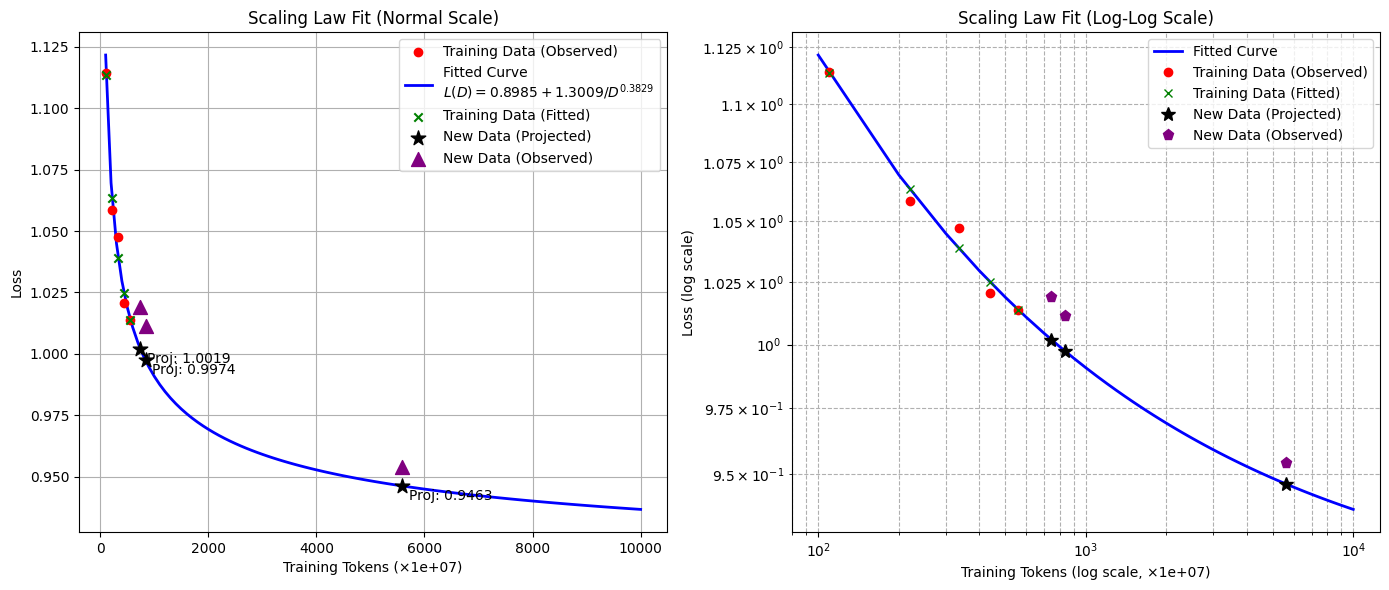

Optimized L_inf: 0.8985
Optimized B: 1.3009
Optimized beta: 0.3829

New Data Predictions:
Tokens: 744.5310000000.0, Observed Loss: 1.0191, Projected Loss: 1.0019
Tokens: 837.5510000000.0, Observed Loss: 1.0112, Projected Loss: 0.9974
Tokens: 5583.6710000000.0, Observed Loss: 0.9540, Projected Loss: 0.9463


In [29]:
popt, pcov = curve_fit(scaling_func, D_values_scaled, L_values, p0=[min(L_values), 5, 0.3])
L_inf_fit, B_fit, beta_fit = popt
print(f"L_inf: {L_inf_fit}, B: {B_fit}, beta: {beta_fit}")

visualize(L_values, D_values_scaled, L_inf_fit, B_fit, beta_fit, preds, tokens_scaling_factor=tokens_scaling_factor)

L_inf: 0.9773064441773317, B: 5.001158123401194, beta: 0.7625588965785991


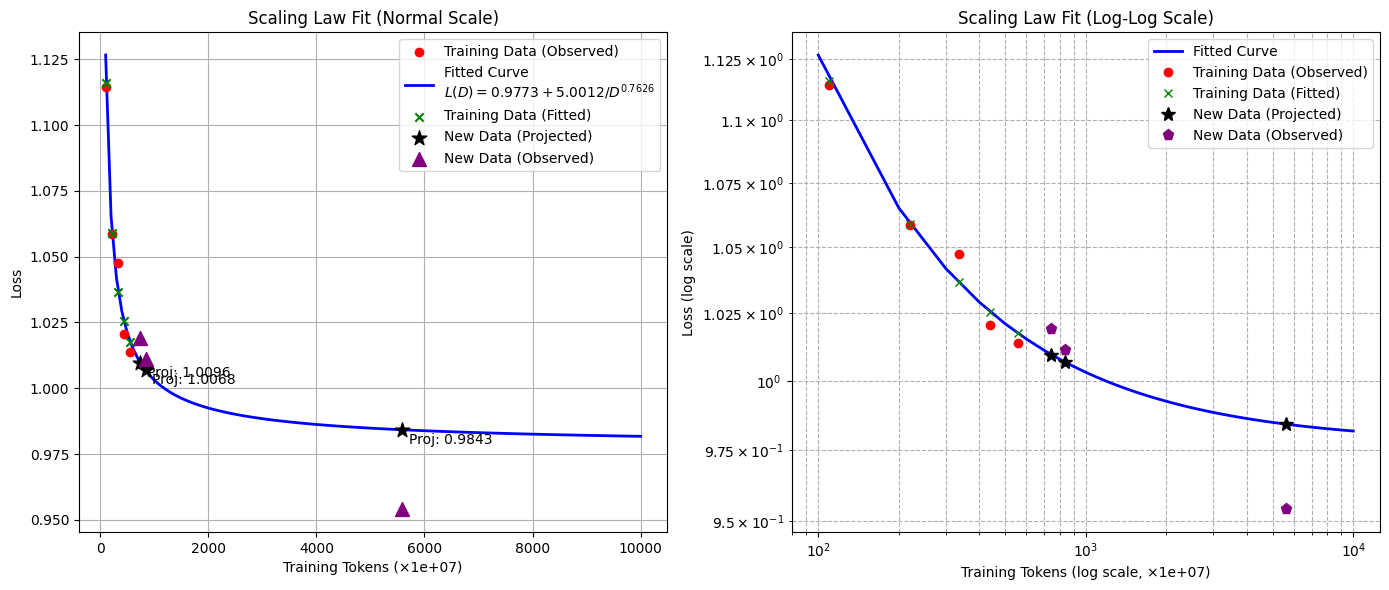

Optimized L_inf: 0.9773
Optimized B: 5.0012
Optimized beta: 0.7626

New Data Predictions:
Tokens: 744.5310000000.0, Observed Loss: 1.0191, Projected Loss: 1.0096
Tokens: 837.5510000000.0, Observed Loss: 1.0112, Projected Loss: 1.0068
Tokens: 5583.6710000000.0, Observed Loss: 0.9540, Projected Loss: 0.9843


In [30]:

# Initial parameter guesses (L_inf, B, beta)
initial_guess = [min(L_values), 5, 0.3]

# Run L-BFGS-B optimization
result = minimize(loss_function, initial_guess, args=(D_values_scaled, L_values), method='L-BFGS-B')

# Extract optimized parameters
L_inf_fit, B_fit, beta_fit = result.x
print(f"L_inf: {L_inf_fit}, B: {B_fit}, beta: {beta_fit}")


visualize(L_values, D_values_scaled, L_inf_fit, B_fit, beta_fit, preds, tokens_scaling_factor=tokens_scaling_factor)


In [ ]:
D_values = np.array([1_101_004_800, 2_202_009_600, 3_355_433_200, 4_404_019_200, 5_583_443_200])
L_values = np.array([1.0505, 0.999, 0.9844, 0.9597, 0.9527])  
D_values_scaled = D_values / 1e9

preds = np.array([(7.445e9, 0.9588), (11.167e9, 0.9306), (5583.667e9,None)])

Scaling Laws for ICML workshops

In [ ]:
import re

def calculate_average_loss(log_text: str) -> float:
    loss_values = []
    # Regular expression to find "loss: " followed by a floating-point number
    # It captures the floating-point number in a group.
    # \d+\.\d+ matches one or more digits, a dot, and one or more digits
    # \s* matches zero or more whitespace characters
    pattern = r"loss:\s*(\d+\.\d+)"

    # Find all occurrences of the pattern in the log_text
    matches = re.findall(pattern, log_text)

    # Convert the captured strings to float and add to the list
    for match in matches:
        try:
            loss_values.append(float(match))
        except ValueError as e:
            print(f"Warning: Could not convert '{match}' to float. Skipping. Error: {e}")

    if not loss_values:
        print("No loss values found in the provided text.")
        return 0.0

    # Calculate the average
    average_loss = sum(loss_values) / len(loss_values)
    return average_loss

# Your provided log text
log_data = """
loss:  1.0556  memory: 60.69GiB(76.72%)  wps: 234,247  mfu: 6.86%  lr: 3.654e-06

"""

# Calculate the average loss
avg_loss = calculate_average_loss(log_data)

# Print the result
print(f"The average loss value is: {avg_loss:.4f}")

The average loss value is: 1.0561


In [2]:
params = np.array([1e8, 1.7e8, 3.8e8, 1e9])
tokens_per_epoch = 2.5e9

losses = np.array([
    [1.1460, 1.1082, 1.0876, 1.0561],
    [1.1238, 1.0863, 1.0648, 1.0429],
    [1.0899, 1.0447, 1.0239, 0.9950],
    [1.0440, 0.9952, 0.9629, 0.9253]
])


all_tokens_seen = []
all_losses = []
all_params_repeated = [] 

for i, num_params in enumerate(params):
    for epoch in range(1, 5): 
        tokens_seen = tokens_per_epoch * epoch
        loss_val = losses[i][epoch - 1] 

        all_tokens_seen.append(tokens_seen)
        all_losses.append(loss_val)
        all_params_repeated.append(num_params)

all_params_repeated = np.array(all_params_repeated)
all_tokens_seen = np.array(all_tokens_seen)
all_losses = np.array(all_losses)


def scaling_law_func(X, A, alpha, B, beta, C):
    N, D = X # X will be a tuple/array of (N, D) values
    return A * (N**-alpha) + B * (D**-beta) + C

In [5]:
all_params_repeated

array([1.0e+08, 1.0e+08, 1.0e+08, 1.0e+08, 1.7e+08, 1.7e+08, 1.7e+08,
       1.7e+08, 3.8e+08, 3.8e+08, 3.8e+08, 3.8e+08, 1.0e+09, 1.0e+09,
       1.0e+09, 1.0e+09])

In [30]:
# --- 4. Perform Curve Fitting ---

# Initial guess for the parameters (A, alpha, B, beta, C)
# Let's try a slightly adjusted guess and C closer to min_loss
# Based on earlier calculations, [7.7, 0.2, 7.7, 0.2, 0.85] was a good start.
# Let's try [5.0, 0.2, 5.0, 0.2, 0.9] (C slightly higher, A/B lower)
# Or even [1.0, 0.1, 1.0, 0.1, 0.9] which is a more generic initial guess,
# sometimes simpler values work better for initial steps.
initial_guess = [7.7, 0.2, 7.7, 0.2, 0.85] # Our calculated robust guess

# Define bounds for the parameters: (A, alpha, B, beta, C)
# A, B: Must be positive (loss contribution)
# alpha, beta: Must be positive (loss decreases with scale)
# C: Must be positive (loss cannot be negative) and less than the minimum observed loss.
min_loss_observed = np.min(all_losses)
lower_bounds = [1e-9, 1e-9, 1e-9, 1e-9, 1e-9] # Slightly above zero
upper_bounds = [np.inf, 1.0, np.inf, 1.0, min_loss_observed * 0.99] # Limit alpha/beta to 1.0, C slightly below min_loss

# Limiting alpha/beta to 1.0 is a common heuristic as they rarely exceed this.
# You can adjust np.inf if you have a sense of max A/B.

print(f"Attempting fit with initial guess: {initial_guess}")
print(f"Using bounds: Lower={lower_bounds}, Upper={upper_bounds}")
print(f"Min observed loss: {min_loss_observed}")

try:
    popt, pcov = curve_fit(scaling_law_func,
                           (all_params_repeated, all_tokens_seen),
                           all_losses,
                           p0=initial_guess,
                           bounds=(lower_bounds, upper_bounds), # Apply bounds
                           maxfev=10000) # Increased maximum function evaluations

    A_fit, alpha_fit, B_fit, beta_fit, C_fit = popt

    print("\n--- Derived Scaling Law Parameters ---")
    print(f"L(N, D) = A * N^-alpha + B * D^-beta + C")
    print(f"A = {A_fit:.4f}")
    print(f"alpha (exponent for parameters) = {alpha_fit:.4f}")
    print(f"B = {B_fit:.4f}")
    print(f"beta (exponent for tokens) = {beta_fit:.4f}")
    print(f"C (irreducible loss) = {C_fit:.4f}")

    # Calculate R-squared for goodness of fit
    residuals = all_losses - scaling_law_func((all_params_repeated, all_tokens_seen), *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((all_losses - np.mean(all_losses))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"\nR-squared (Goodness of Fit): {r_squared:.4f}")

    # --- Test the fit ---
    print("\n--- Fit Test ---")
    predicted_losses = scaling_law_func((all_params_repeated, all_tokens_seen), *popt)
    for i in range(len(all_losses)):
        print(f"Actual Loss: {all_losses[i]:.4f}, Predicted Loss: {predicted_losses[i]:.4f}")

except RuntimeError as e:
    print(f"\nError during curve fitting: {e}")
    print("This often means the optimizer could not find a solution.")
    print("Suggestions:")
    print("1. Adjust `initial_guess`. Try slightly different values, especially for A, B, and C.")
    print("2. Adjust `bounds`. Make them tighter if you have strong prior knowledge, or looser if the fit is getting stuck at a boundary.")
    print("3. Simplify the model. Try fitting just L(N) or L(D) first to see if those relationships hold.")
    print("   E.g., L(N) = A * N^-alpha + C using only the final epoch data for all models.")
    print("4. Examine your data for outliers or inconsistencies. Plot it in 3D if possible.")



Attempting fit with initial guess: [7.7, 0.2, 7.7, 0.2, 0.85]
Using bounds: Lower=[1e-09, 1e-09, 1e-09, 1e-09, 1e-09], Upper=[inf, 1.0, inf, 1.0, 0.9160470000000001]
Min observed loss: 0.9253

--- Derived Scaling Law Parameters ---
L(N, D) = A * N^-alpha + B * D^-beta + C
A = 3.1739
alpha (exponent for parameters) = 0.0845
B = 12.6149
beta (exponent for tokens) = 0.1501
C (irreducible loss) = 0.0000

R-squared (Goodness of Fit): 0.9772

--- Fit Test ---
Actual Loss: 1.1460, Predicted Loss: 1.1583
Actual Loss: 1.1082, Predicted Loss: 1.1099
Actual Loss: 1.0876, Predicted Loss: 1.0838
Actual Loss: 1.0561, Predicted Loss: 1.0663
Actual Loss: 1.1238, Predicted Loss: 1.1289
Actual Loss: 1.0863, Predicted Loss: 1.0805
Actual Loss: 1.0648, Predicted Loss: 1.0545
Actual Loss: 1.0429, Predicted Loss: 1.0369
Actual Loss: 1.0899, Predicted Loss: 1.0869
Actual Loss: 1.0447, Predicted Loss: 1.0385
Actual Loss: 1.0239, Predicted Loss: 1.0124
Actual Loss: 0.9950, Predicted Loss: 0.9949
Actual Loss: 1

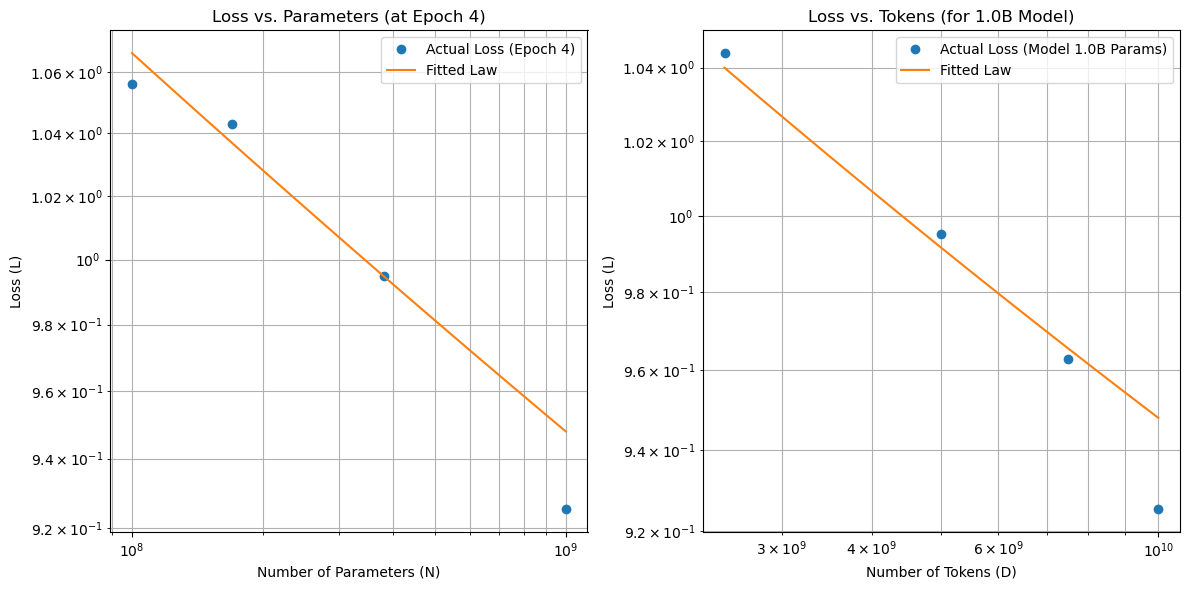

In [31]:
# --- 5. Visualization (Optional, but Recommended for understanding) ---

# Plot Loss vs. Parameters (holding tokens constant, e.g., at epoch 4)
plt.figure(figsize=(12, 6))

epoch_to_plot = 4 # Plotting based on data from the final epoch

# Filter data for the chosen epoch
params_for_plot = params
losses_for_plot = np.array([losses[i][epoch_to_plot-1] for i in range(len(params))])
tokens_for_plot = np.array([tokens_per_epoch * epoch_to_plot] * len(params))


plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.loglog(params_for_plot, losses_for_plot, 'o', label=f'Actual Loss (Epoch {epoch_to_plot})')
if 'popt' in locals():
    # Generate predicted values for plotting the fit
    N_pred = np.logspace(np.log10(params.min()), np.log10(params.max()), 100)
    D_pred_fixed = np.array([tokens_per_epoch * epoch_to_plot] * len(N_pred))
    L_pred = scaling_law_func((N_pred, D_pred_fixed), *popt)
    plt.loglog(N_pred, L_pred, '-', label='Fitted Law')

plt.title(f'Loss vs. Parameters (at Epoch {epoch_to_plot})')
plt.xlabel('Number of Parameters (N)')
plt.ylabel('Loss (L)')
plt.grid(True, which="both", ls="-")
plt.legend()


# Plot Loss vs. Tokens (for a specific model size)
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot

model_index_to_plot = 3 # Plotting for the largest model size (params[3] = 1e9)
specific_params_val = params[model_index_to_plot]

tokens_seen_model = np.array([tokens_per_epoch * epoch for epoch in range(1, 5)])
losses_model = losses[model_index_to_plot]

plt.loglog(tokens_seen_model, losses_model, 'o', label=f'Actual Loss (Model {specific_params_val/1e9:.1f}B Params)')
if 'popt' in locals():
    # Generate predicted values for plotting the fit
    D_pred = np.logspace(np.log10(tokens_seen_model.min()), np.log10(tokens_seen_model.max()), 100)
    N_pred_fixed = np.array([specific_params_val] * len(D_pred))
    L_pred = scaling_law_func((N_pred_fixed, D_pred), *popt)
    plt.loglog(D_pred, L_pred, '-', label='Fitted Law')

plt.title(f'Loss vs. Tokens (for {specific_params_val/1e9:.1f}B Model)')
plt.xlabel('Number of Tokens (D)')
plt.ylabel('Loss (L)')
plt.grid(True, which="both", ls="-")
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
if popt is not None: # Only proceed if curve_fit was successful
    A_fit, alpha_fit, B_fit, beta_fit, C_fit = popt
    target_model_params = 3e9 # 3 Billion parameters

    print(f"\n--- Predictions for a {target_model_params/1e9:.1f} Billion Parameter Model ---")

    # Option 1: Predict tokens needed for a target loss
    try:
        target_loss_input = float(input(f"Enter a target loss value (e.g., {min_loss_observed:.4f} to {np.max(all_losses):.4f}): "))

        # Rearrange the scaling law to solve for D:
        # L = A * N^-alpha + B * D^-beta + C
        # L - C - A * N^-alpha = B * D^-beta
        # (L - C - A * N^-alpha) / B = D^-beta
        # D = ((L - C - A * N^-alpha) / B)^(-1/beta)

        numerator = target_loss_input - C_fit - A_fit * (target_model_params**-alpha_fit)

        if B_fit <= 0:
            print("Cannot predict tokens: B parameter is non-positive, which is not expected for a decreasing loss curve.")
        elif numerator <= 0:
            print(f"Target loss {target_loss_input:.4f} is too low or unachievable for a {target_model_params/1e9:.1f}B model based on the derived law.")
            print(f"The minimum theoretical loss for this model (if D approaches infinity) is approximately {C_fit + A_fit * (target_model_params**-alpha_fit):.4f}")
        elif beta_fit <= 0:
            print("Cannot predict tokens: Beta parameter is non-positive, which is not expected for a decreasing loss curve with more tokens.")
        else:
            tokens_needed = (numerator / B_fit)**(-1/beta_fit)
            print(f"To achieve a loss of {target_loss_input:.4f}, you would need approximately {tokens_needed/1e9:.2f} billion tokens.")
            print(f"This corresponds to {tokens_needed / tokens_per_epoch:.2f} epochs of your current dataset.")

    except ValueError:
        print("Invalid input for target loss. Please enter a number.")
    except Exception as e:
        print(f"An unexpected error occurred during token prediction: {e}")

    print("-" * 50)

    # Option 2: Predict loss for a given number of tokens
    try:
        tokens_to_predict_input = float(input("Enter a number of tokens (e.g., 10e9 for 1 epoch, 40e9 for 4 epochs): "))
        predicted_loss_for_tokens = scaling_law_func((target_model_params, tokens_to_predict_input), *popt)
        print(f"For a {target_model_params/1e9:.1f}B model trained on {tokens_to_predict_input/1e9:.2f} billion tokens, the predicted loss is: {predicted_loss_for_tokens:.4f}")
    except ValueError:
        print("Invalid input for tokens. Please enter a number.")
    except Exception as e:
        print(f"An unexpected error occurred during loss prediction: {e}")

else:
    print("\nSkipping prediction phase due to failed curve fitting.")

print("\n--- End of Script ---")



--- Predictions for a 3.0 Billion Parameter Model ---
Invalid input for target loss. Please enter a number.
--------------------------------------------------
For a 3.0B model trained on 0.00 billion tokens, the predicted loss is: 9.4292

--- End of Script ---


Fitting Kaplan et al. unified scaling law...
L(N,D) = A + B/N^α + C/D^β
--------------------------------------------------

SCALING LAW ANALYSIS
Fitted Parameters:
  A (asymptotic loss): 0.791552
  B (parameter coeff): 3.54e+06
  α (parameter exp):   0.873818
  C (data coeff):      1.00e+06
  β (data exp):        0.759007

Model Performance:
  R²:   -1.209003
  RMSE: 0.085209
  MAE:  0.075983

Scaling Insights:
  • Doubling parameters reduces loss by 45.43%
  • Doubling training data reduces loss by 40.91%
  • Parameter/Data efficiency ratio: 1.15
    → Parameters are more efficient than data for reducing loss

Optimal Resource Allocation:
  • Optimal N/D ratio: 5.02e-01


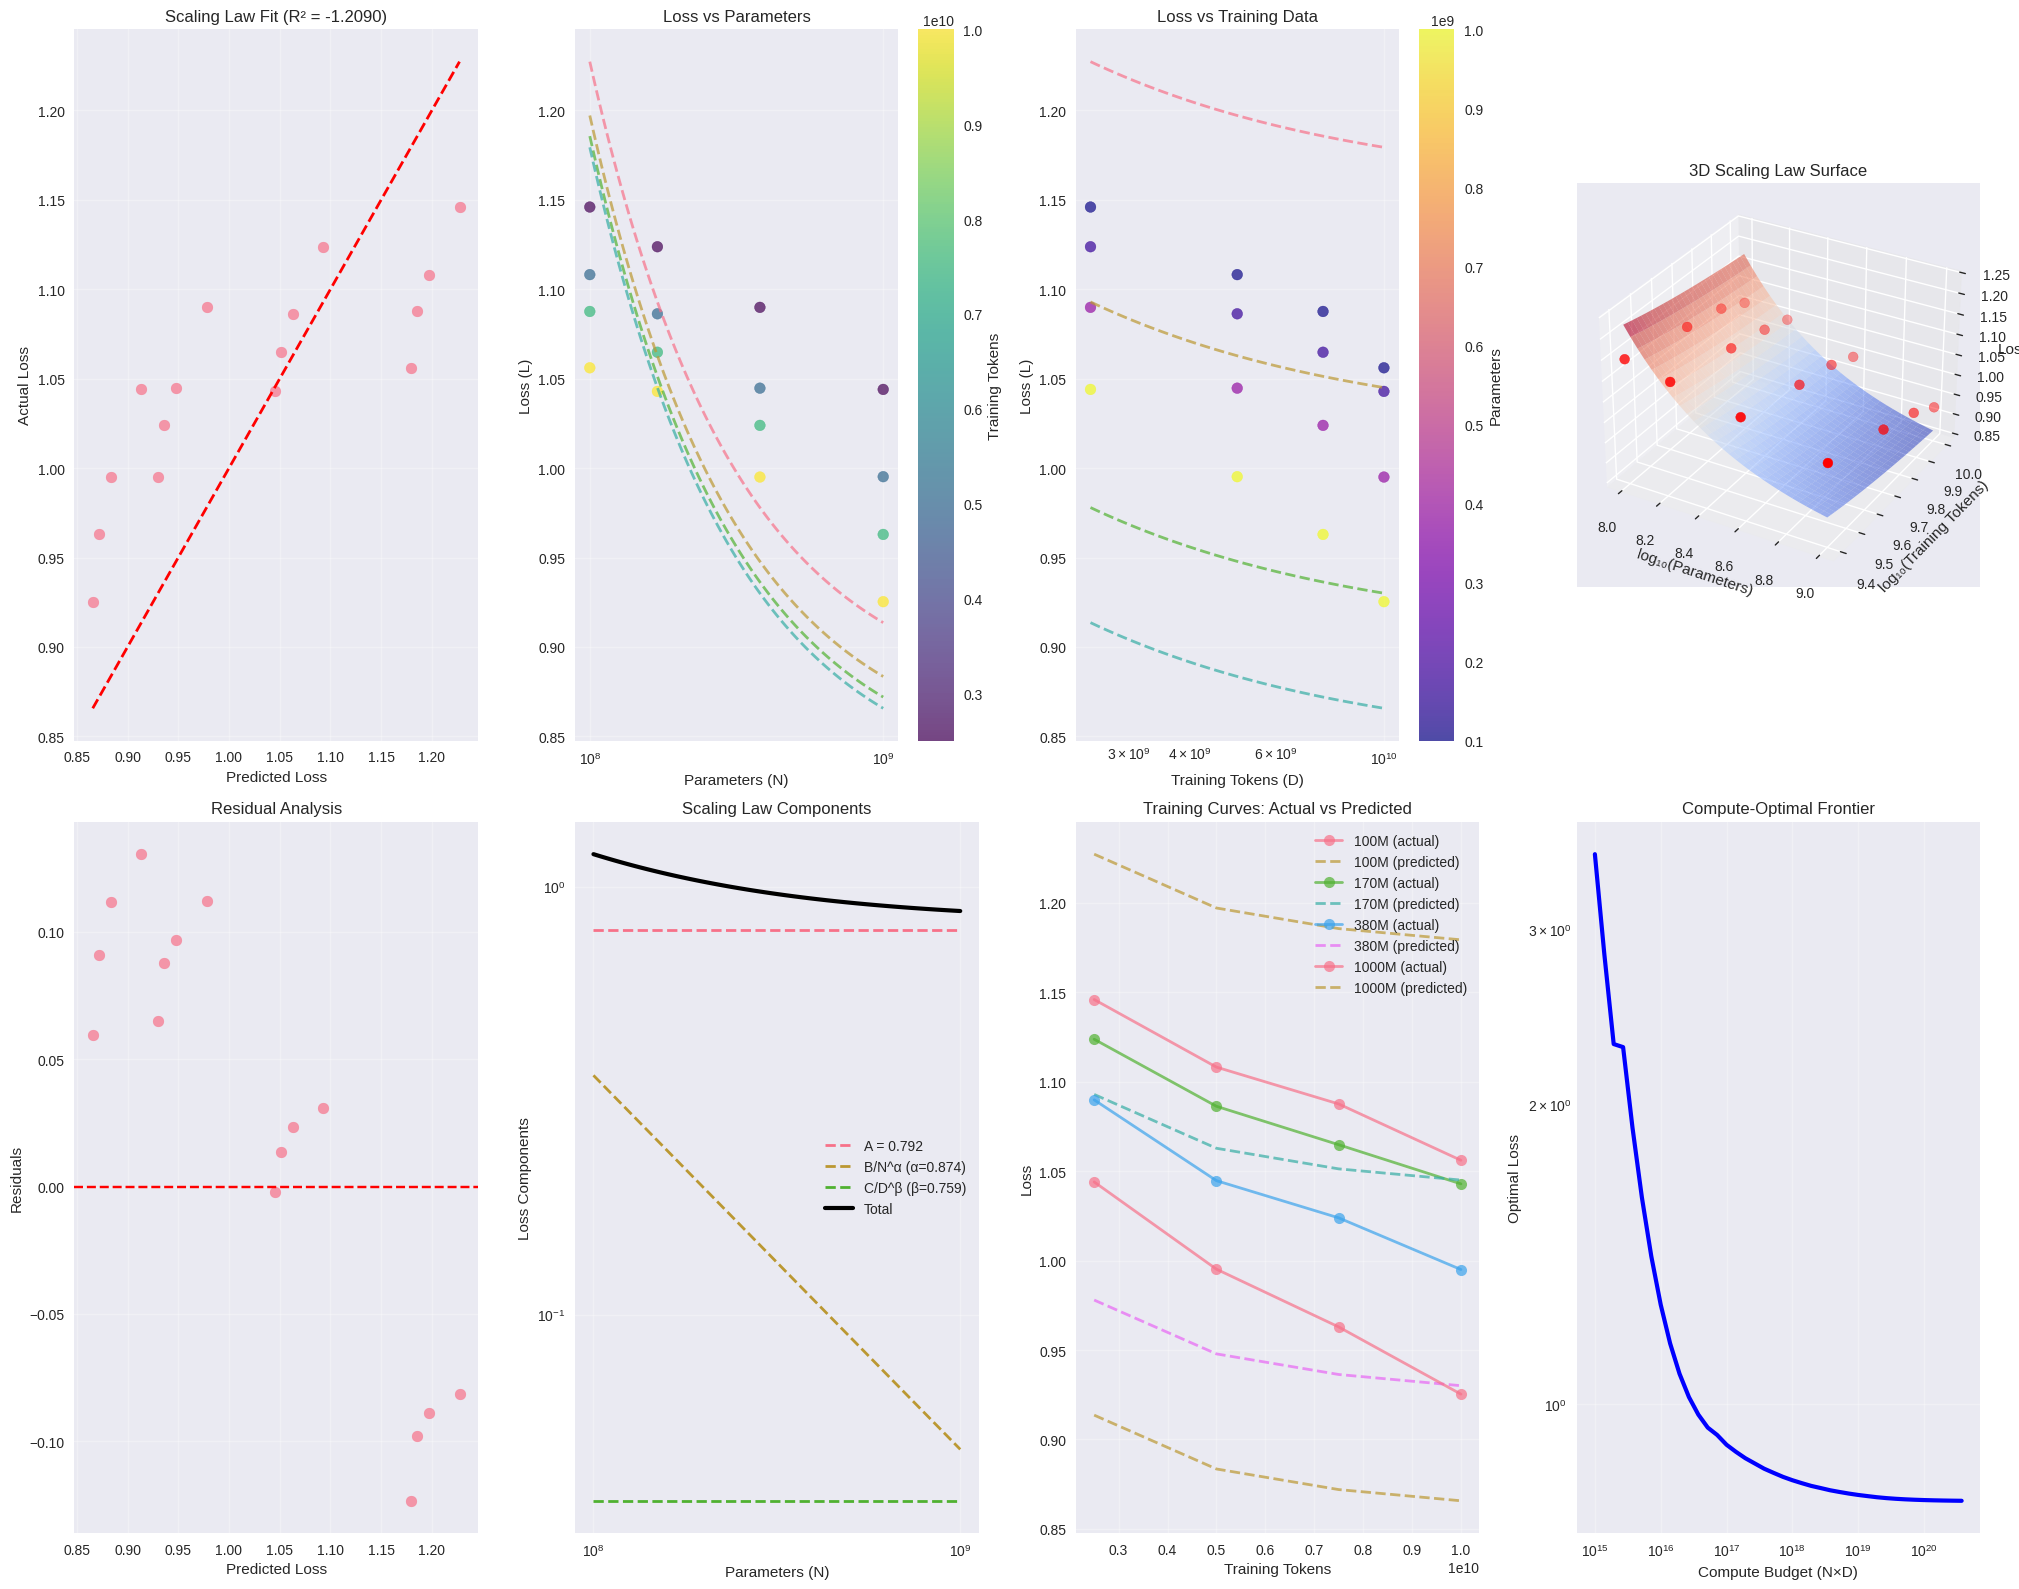


FITTED SCALING LAW
L(N,D) = 0.7916 + 3.54e+06/N^0.8738 + 1.00e+06/D^0.7590
where N = parameters, D = training tokens

KAPLAN SCALING LAWS ANALYSIS COMPLETE


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class KaplanScalingLaws:
    """
    Implementation of Kaplan et al. scaling laws methodology.
    Fits a unified scaling law: L(N,D) = A + B/N^α + C/D^β
    where N = parameters, D = tokens, L = loss
    """
    
    def __init__(self, params, tokens_per_epoch, losses):
        self.params = np.array(params)
        self.tokens_per_epoch = tokens_per_epoch
        self.losses = np.array(losses)
        self.n_params = len(params)
        self.n_epochs = losses.shape[1]
        
        # Prepare full dataset
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare the unified dataset with all parameter-token-loss combinations."""
        self.N = []  # Parameters
        self.D = []  # Tokens (compute)
        self.L = []  # Losses
        self.model_sizes = []
        self.epochs = []
        
        for i, param_count in enumerate(self.params):
            for epoch in range(self.n_epochs):
                self.N.append(param_count)
                self.D.append(self.tokens_per_epoch * (epoch + 1))
                self.L.append(self.losses[i, epoch])
                self.model_sizes.append(i)
                self.epochs.append(epoch + 1)
        
        self.N = np.array(self.N)
        self.D = np.array(self.D)
        self.L = np.array(self.L)
    
    def kaplan_loss_function(self, params, N, D):
        """
        Kaplan et al. scaling law: L(N,D) = A + B/N^α + C/D^β
        
        Args:
            params: [A, B, α, C, β] - scaling law parameters
            N: Number of model parameters
            D: Number of training tokens (compute)
        
        Returns:
            Predicted loss
        """
        A, B, alpha, C, beta = params
        return A + B / (N**alpha) + C / (D**beta)
    
    def loss_function_objective(self, params):
        """Objective function for optimization (MSE)."""
        predicted = self.kaplan_loss_function(params, self.N, self.D)
        mse = np.mean((self.L - predicted)**2)
        return mse
    
    def fit_scaling_law(self):
        """Fit the unified Kaplan scaling law using optimization."""
        print("Fitting Kaplan et al. unified scaling law...")
        print("L(N,D) = A + B/N^α + C/D^β")
        print("-" * 50)
        
        # Initial parameter guesses
        # A: asymptotic loss (minimum possible loss)
        # B: parameter scaling coefficient  
        # α: parameter scaling exponent
        # C: data scaling coefficient
        # β: data scaling exponent
        initial_guess = [
            0.8,    # A: asymptotic loss
            1e10,   # B: parameter coefficient
            0.1,    # α: parameter exponent
            1e10,   # C: data coefficient  
            0.1     # β: data exponent
        ]
        
        # Parameter bounds (reasonable constraints)
        bounds = [
            (0.5, 1.5),      # A: asymptotic loss
            (1e6, 1e15),     # B: parameter coefficient
            (0.01, 1.0),     # α: parameter exponent
            (1e6, 1e15),     # C: data coefficient
            (0.01, 1.0)      # β: data exponent
        ]
        
        # Optimize using multiple methods for robustness
        methods = ['L-BFGS-B', 'SLSQP', 'TNC']
        best_result = None
        best_loss = float('inf')
        
        for method in methods:
            try:
                result = minimize(
                    self.loss_function_objective,
                    initial_guess,
                    method=method,
                    bounds=bounds,
                    options={'maxiter': 10000}
                )
                
                if result.success and result.fun < best_loss:
                    best_result = result
                    best_loss = result.fun
                    
            except Exception as e:
                print(f"Method {method} failed: {e}")
                continue
        
        if best_result is None:
            raise ValueError("All optimization methods failed!")
        
        # Extract fitted parameters
        self.A, self.B, self.alpha, self.C, self.beta = best_result.x
        
        # Calculate model performance metrics
        self.predicted_losses = self.kaplan_loss_function(best_result.x, self.N, self.D)
        self.r_squared = r2_score(self.L, self.predicted_losses)
        self.rmse = np.sqrt(np.mean((self.L - self.predicted_losses)**2))
        self.mae = np.mean(np.abs(self.L - self.predicted_losses))
        
        # Store results
        self.fitted_params = best_result.x
        self.optimization_result = best_result
        
        return best_result.x
    
    def analyze_scaling_components(self):
        """Analyze the relative contributions of parameters vs data scaling."""
        print("\nSCALING LAW ANALYSIS")
        print("=" * 60)
        
        # Parameter contributions at different scales
        N_range = np.logspace(np.log10(self.N.min()), np.log10(self.N.max()), 100)
        D_fixed = np.median(self.D)  # Fix data at median
        
        param_contributions = self.B / (N_range**self.alpha)
        
        # Data contributions at different scales  
        D_range = np.logspace(np.log10(self.D.min()), np.log10(self.D.max()), 100)
        N_fixed = np.median(self.N)  # Fix parameters at median
        
        data_contributions = self.C / (D_range**self.beta)
        
        print(f"Fitted Parameters:")
        print(f"  A (asymptotic loss): {self.A:.6f}")
        print(f"  B (parameter coeff): {self.B:.2e}")
        print(f"  α (parameter exp):   {self.alpha:.6f}")
        print(f"  C (data coeff):      {self.C:.2e}")
        print(f"  β (data exp):        {self.beta:.6f}")
        
        print(f"\nModel Performance:")
        print(f"  R²:   {self.r_squared:.6f}")
        print(f"  RMSE: {self.rmse:.6f}")
        print(f"  MAE:  {self.mae:.6f}")
        
        print(f"\nScaling Insights:")
        # Parameter efficiency
        param_reduction = (1 - 2**(-self.alpha)) * 100
        print(f"  • Doubling parameters reduces loss by {param_reduction:.2f}%")
        
        # Data efficiency  
        data_reduction = (1 - 2**(-self.beta)) * 100
        print(f"  • Doubling training data reduces loss by {data_reduction:.2f}%")
        
        # Efficiency comparison
        efficiency_ratio = self.alpha / self.beta
        print(f"  • Parameter/Data efficiency ratio: {efficiency_ratio:.2f}")
        
        if efficiency_ratio > 1:
            print("    → Parameters are more efficient than data for reducing loss")
        else:
            print("    → Data is more efficient than parameters for reducing loss")
        
        # Compute optimal allocation
        print(f"\nOptimal Resource Allocation:")
        total_compute_budget = 1e20  # Example compute budget
        optimal_ratio = (self.alpha * self.C / (self.beta * self.B))**(1/(self.alpha + self.beta))
        print(f"  • Optimal N/D ratio: {optimal_ratio:.2e}")
        
    def create_visualizations(self):
        """Create comprehensive visualizations following Kaplan methodology."""
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Main scaling law fit
        ax1 = plt.subplot(2, 4, 1)
        
        # Plot actual vs predicted
        plt.scatter(self.predicted_losses, self.L, alpha=0.7, s=60)
        min_loss, max_loss = min(self.L.min(), self.predicted_losses.min()), max(self.L.max(), self.predicted_losses.max())
        plt.plot([min_loss, max_loss], [min_loss, max_loss], 'r--', linewidth=2)
        plt.xlabel('Predicted Loss')
        plt.ylabel('Actual Loss')
        plt.title(f'Scaling Law Fit (R² = {self.r_squared:.4f})')
        plt.grid(True, alpha=0.3)
        
        # 2. Loss vs Parameters (with data size colored)
        ax2 = plt.subplot(2, 4, 2)
        scatter = plt.scatter(self.N, self.L, c=self.D, cmap='viridis', s=60, alpha=0.7)
        
        # Plot scaling law prediction for fixed data
        N_range = np.logspace(np.log10(self.N.min()), np.log10(self.N.max()), 100)
        for D_fixed in [self.tokens_per_epoch * e for e in [1, 2, 3, 4]]:
            L_pred = self.kaplan_loss_function(self.fitted_params, N_range, D_fixed)
            plt.plot(N_range, L_pred, '--', alpha=0.7, linewidth=2)
        
        plt.xscale('log')
        plt.xlabel('Parameters (N)')
        plt.ylabel('Loss (L)')
        plt.title('Loss vs Parameters')
        plt.colorbar(scatter, label='Training Tokens')
        plt.grid(True, alpha=0.3)
        
        # 3. Loss vs Training Data (with model size colored) 
        ax3 = plt.subplot(2, 4, 3)
        scatter = plt.scatter(self.D, self.L, c=self.N, cmap='plasma', s=60, alpha=0.7)
        
        # Plot scaling law prediction for fixed parameters
        D_range = np.logspace(np.log10(self.D.min()), np.log10(self.D.max()), 100)
        for N_fixed in self.params:
            L_pred = self.kaplan_loss_function(self.fitted_params, N_fixed, D_range)
            plt.plot(D_range, L_pred, '--', alpha=0.7, linewidth=2)
        
        plt.xscale('log')
        plt.xlabel('Training Tokens (D)')
        plt.ylabel('Loss (L)')
        plt.title('Loss vs Training Data')
        plt.colorbar(scatter, label='Parameters')
        plt.grid(True, alpha=0.3)
        
        # 4. 3D Surface Plot
        ax4 = plt.subplot(2, 4, 4, projection='3d')
        
        # Create meshgrid for surface
        log_N = np.linspace(np.log10(self.N.min()), np.log10(self.N.max()), 30)
        log_D = np.linspace(np.log10(self.D.min()), np.log10(self.D.max()), 30)
        Log_N, Log_D = np.meshgrid(log_N, log_D)
        N_mesh, D_mesh = 10**Log_N, 10**Log_D
        
        L_surface = self.kaplan_loss_function(self.fitted_params, N_mesh, D_mesh)
        
        # Plot surface and data points
        ax4.plot_surface(Log_N, Log_D, L_surface, alpha=0.6, cmap='coolwarm')
        ax4.scatter(np.log10(self.N), np.log10(self.D), self.L, c='red', s=50)
        
        ax4.set_xlabel('log₁₀(Parameters)')
        ax4.set_ylabel('log₁₀(Training Tokens)')
        ax4.set_zlabel('Loss')
        ax4.set_title('3D Scaling Law Surface')
        
        # 5. Residuals Analysis
        ax5 = plt.subplot(2, 4, 5)
        residuals = self.L - self.predicted_losses
        plt.scatter(self.predicted_losses, residuals, alpha=0.7, s=60)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Loss')
        plt.ylabel('Residuals')
        plt.title('Residual Analysis')
        plt.grid(True, alpha=0.3)
        
        # 6. Scaling Components
        ax6 = plt.subplot(2, 4, 6)
        
        # Plot individual components
        N_range = np.logspace(np.log10(self.N.min()), np.log10(self.N.max()), 100)
        D_median = np.median(self.D)
        
        asymptotic = np.full_like(N_range, self.A)
        param_component = self.B / (N_range**self.alpha)
        data_component = self.C / (D_median**self.beta)
        total = asymptotic + param_component + data_component
        
        plt.loglog(N_range, asymptotic, '--', label=f'A = {self.A:.3f}', linewidth=2)
        plt.loglog(N_range, param_component, '--', label=f'B/N^α (α={self.alpha:.3f})', linewidth=2)
        plt.loglog(N_range, np.full_like(N_range, data_component), '--', 
                  label=f'C/D^β (β={self.beta:.3f})', linewidth=2)
        plt.loglog(N_range, total, 'k-', label='Total', linewidth=3)
        
        plt.xlabel('Parameters (N)')
        plt.ylabel('Loss Components')
        plt.title('Scaling Law Components')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. Training Curves
        ax7 = plt.subplot(2, 4, 7)
        
        for i, param_count in enumerate(self.params):
            epochs_range = range(1, self.n_epochs + 1)
            tokens_range = [self.tokens_per_epoch * e for e in epochs_range]
            actual_losses = self.losses[i, :]
            
            # Predicted losses
            predicted = [self.kaplan_loss_function(self.fitted_params, param_count, tokens) 
                        for tokens in tokens_range]
            
            plt.plot(tokens_range, actual_losses, 'o-', linewidth=2, markersize=8,
                    label=f'{param_count/1e6:.0f}M (actual)', alpha=0.7)
            plt.plot(tokens_range, predicted, '--', linewidth=2,
                    label=f'{param_count/1e6:.0f}M (predicted)', alpha=0.7)
        
        plt.xlabel('Training Tokens')
        plt.ylabel('Loss')
        plt.title('Training Curves: Actual vs Predicted')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        
        # 8. Compute Optimal Frontier
        ax8 = plt.subplot(2, 4, 8)
        
        # For fixed compute budgets, find optimal N,D allocation
        compute_budgets = np.logspace(15, 22, 50)  # Various compute budgets
        optimal_losses = []
        optimal_N = []
        optimal_D = []
        
        for C_budget in compute_budgets:
            # Assuming compute ∝ N * D
            # Optimize L(N,D) subject to N*D = C_budget
            best_loss = float('inf')
            best_n, best_d = None, None
            
            # Grid search over reasonable N values
            for N_test in np.logspace(7, 10, 20):
                D_test = C_budget / N_test
                if D_test < self.tokens_per_epoch:  # Minimum data requirement
                    continue
                    
                loss_test = self.kaplan_loss_function(self.fitted_params, N_test, D_test)
                if loss_test < best_loss:
                    best_loss = loss_test
                    best_n, best_d = N_test, D_test
            
            if best_n is not None:
                optimal_losses.append(best_loss)
                optimal_N.append(best_n)
                optimal_D.append(best_d)
        
        if optimal_losses:
            plt.loglog(compute_budgets[:len(optimal_losses)], optimal_losses, 'b-', linewidth=3)
            plt.xlabel('Compute Budget (N×D)')
            plt.ylabel('Optimal Loss')
            plt.title('Compute-Optimal Frontier')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print the scaling law equation
        print(f"\n" + "="*60)
        print("FITTED SCALING LAW")
        print("="*60)
        print(f"L(N,D) = {self.A:.4f} + {self.B:.2e}/N^{self.alpha:.4f} + {self.C:.2e}/D^{self.beta:.4f}")
        print(f"where N = parameters, D = training tokens")

# Run the analysis
if __name__ == "__main__":
    # Your data
    params = np.array([1e8, 1.7e8, 3.8e8, 1e9])
    tokens_per_epoch = 2.5e9
    
    losses = np.array([
        [1.1460, 1.1082, 1.0876, 1.0561],
        [1.1238, 1.0863, 1.0648, 1.0429],
        [1.0899, 1.0447, 1.0239, 0.9950],
        [1.0440, 0.9952, 0.9629, 0.9253]
    ])
    
    # Create and run Kaplan-style analysis
    analyzer = KaplanScalingLaws(params, tokens_per_epoch, losses)
    
    # Fit the unified scaling law
    fitted_params = analyzer.fit_scaling_law()
    
    # Analyze the results
    analyzer.analyze_scaling_components()
    
    # Create comprehensive visualizations
    analyzer.create_visualizations()
    
    print("\n" + "="*60)
    print("KAPLAN SCALING LAWS ANALYSIS COMPLETE")
    print("="*60)

Optimized scaling law: loss ≈ 11.6436 · N^-0.0641 · D^-0.0499


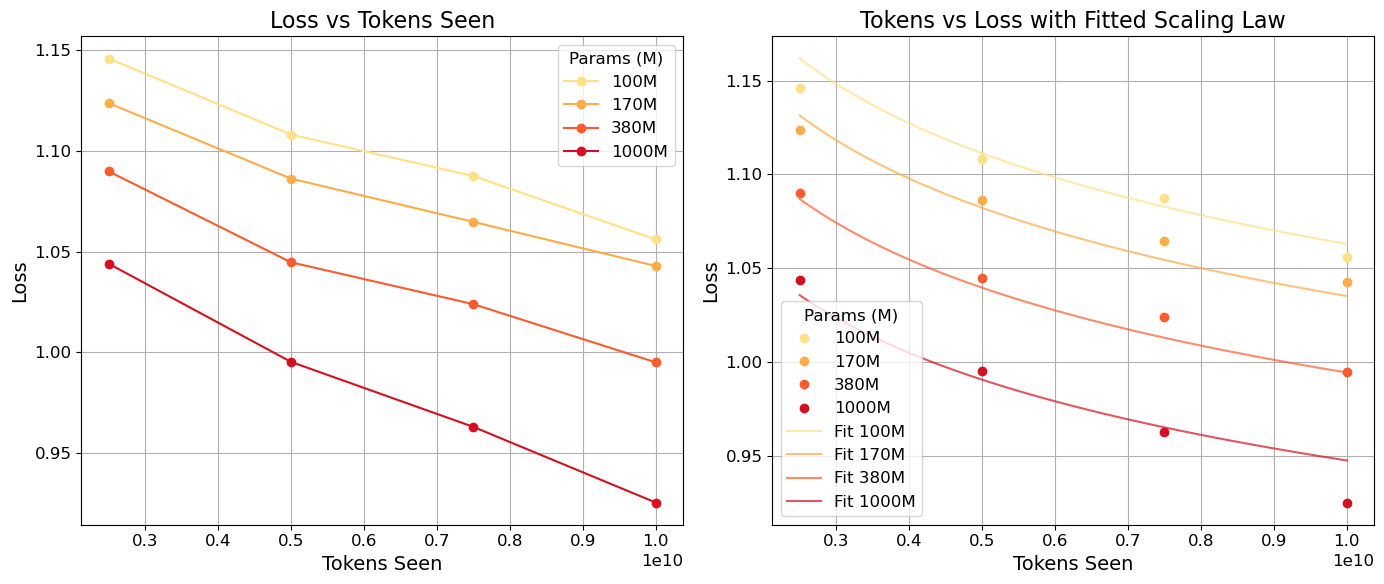

(None, (11.64364332655642, -0.06405610780572889, -0.04987240999998758))

In [50]:
# Re-import required packages after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Use consistent Seaborn palette for model sizes
colors = sns.color_palette("YlOrRd", 4)

# Define data
params = np.array([1e8, 1.7e8, 3.8e8, 1e9])
tokens_per_epoch = 2.5e9
losses = np.array([
    [1.1460, 1.1082, 1.0876, 1.0561],
    [1.1238, 1.0863, 1.0648, 1.0429],
    [1.0899, 1.0447, 1.0239, 0.9950],
    [1.0440, 0.9952, 0.9629, 0.9253]
])
# val_losses = np.array([
#     [0.8685, 0.8426, 0.8281, 0.8098],
#     [0.9146, 0.8879, 0.8722, 0.8567],
#     [0.8686, 0.8053, 0.7934, 0.7741],
#     [0.8577, 0.8252, 0.8063, 0.7885]
# ])
# losses = losses
# losses = losses[[0,1,3]]
losses = losses.T   

epochs = losses.shape[1]
tokens_seen = np.arange(1, epochs + 1) * tokens_per_epoch

# Flatten data
N, D, Y = [], [], []
for i in range(len(params)):
    for j in range(epochs):
        # if j ==2:
        #     continue
        N.append(tokens_seen[j])
        D.append(params[i])
        Y.append(losses[j, i])

N = np.array(N)
D = np.array(D)
Y = np.array(Y)

# Fit scaling law: L = a * N^b * D^c using log-log regression
logN = np.log10(N)
logD = np.log10(D)
logY = np.log10(Y)
X = np.stack([logN, logD], axis=1)

reg = LinearRegression().fit(X, logY)
loga, b, c = reg.intercept_, reg.coef_[0], reg.coef_[1]
a = 10**loga


from scipy.optimize import minimize

# Objective: minimize squared error in log space
def loss_fn(x, logN, logD, logY):
    loga, b, c = x
    pred_logY = loga + b * logN + c * logD
    return np.mean((pred_logY - logY)**2)

# Initial guess from linear regression
x0 = [loga, b, c]
res = minimize(loss_fn, x0, args=(logN, logD, logY), method='L-BFGS-B')

loga_opt, b_opt, c_opt = res.x
a_opt = 10 ** loga_opt
print(f"Optimized scaling law: loss ≈ {a_opt:.4f} · N^{b_opt:.4f} · D^{c_opt:.4f}")

# Predicted loss
Y_pred = a * (N**c) * (D**b)

# Visualization: Loss vs Tokens and Actual vs Predicted Loss
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Loss vs Tokens Seen
for i, color in enumerate(colors):
    axs[0].plot(tokens_seen, losses[:, i], label=f"{params[i]/1e6:.0f}M", color=color, marker='o')
axs[0].set_xlabel("Tokens Seen")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss vs Tokens Seen")
axs[0].legend(title="Params (M)")
axs[0].grid(True)

# Plot 2: Tokens vs Loss with fitted scaling law curve
for i, color in enumerate(colors):
    axs[1].plot(tokens_seen, losses[:, i], 'o', label=f"{params[i]/1e6:.0f}M", color=color)

# Generate a smooth range of tokens for the fit curve (using the largest model as example)
tokens_fit = np.linspace(tokens_seen.min(), tokens_seen.max(), 100)
for i, color in enumerate(colors):
    fitted_loss = a * (tokens_fit**b) * (params[i]**c)
    axs[1].plot(tokens_fit, fitted_loss, '-', color=color, alpha=0.7, label=f"Fit {params[i]/1e6:.0f}M")

axs[1].set_xlabel("Tokens Seen")
axs[1].set_ylabel("Loss")
axs[1].set_title("Tokens vs Loss with Fitted Scaling Law")
axs[1].legend(title="Params (M)")
axs[1].grid(True)
plt.tight_layout()
plt.show(), (a, b, c)

In [51]:
for n, d, y in zip(N, D, Y):
    print(f"Tokens: {n:.0f}, Params: {d:.0f}, Loss: {y:.4f}")

Tokens: 2500000000, Params: 100000000, Loss: 1.1460
Tokens: 5000000000, Params: 100000000, Loss: 1.1082
Tokens: 7500000000, Params: 100000000, Loss: 1.0876
Tokens: 10000000000, Params: 100000000, Loss: 1.0561
Tokens: 2500000000, Params: 170000000, Loss: 1.1238
Tokens: 5000000000, Params: 170000000, Loss: 1.0863
Tokens: 7500000000, Params: 170000000, Loss: 1.0648
Tokens: 10000000000, Params: 170000000, Loss: 1.0429
Tokens: 2500000000, Params: 380000000, Loss: 1.0899
Tokens: 5000000000, Params: 380000000, Loss: 1.0447
Tokens: 7500000000, Params: 380000000, Loss: 1.0239
Tokens: 10000000000, Params: 380000000, Loss: 0.9950
Tokens: 2500000000, Params: 1000000000, Loss: 1.0440
Tokens: 5000000000, Params: 1000000000, Loss: 0.9952
Tokens: 7500000000, Params: 1000000000, Loss: 0.9629
Tokens: 10000000000, Params: 1000000000, Loss: 0.9253


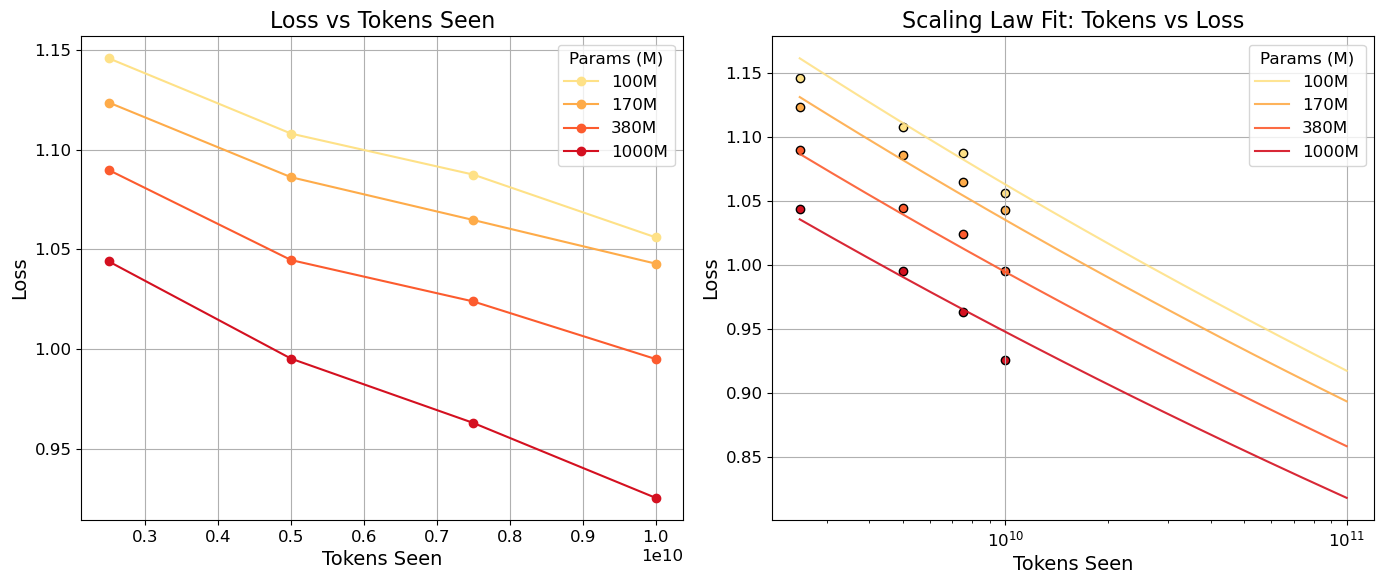

(None, (11.65395540953589, -0.06409044986719825, -0.04987829753851226))

In [23]:
# Re-import required packages after kernel reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Use consistent Seaborn palette for model sizes
colors = sns.color_palette("YlOrRd", 4)

# Define data
params = np.array([1e8, 1.7e8, 3.8e8, 1e9])
tokens_per_epoch = 2.5e9
losses = np.array([
    [1.1460, 1.1082, 1.0876, 1.0561],
    [1.1238, 1.0863, 1.0648, 1.0429],
    [1.0899, 1.0447, 1.0239, 0.9950],
    [1.0440, 0.9952, 0.9629, 0.9253]
])
losses = losses.T
epochs = losses.shape[0]
tokens_seen = np.arange(1, epochs + 1) * tokens_per_epoch

# Flatten data
N, D, Y = [], [], []
for i in range(len(params)):
    for j in range(epochs):
        N.append(tokens_seen[j])
        D.append(params[i])
        Y.append(losses[j, i])
N = np.array(N)
D = np.array(D)
Y = np.array(Y)

# Fit scaling law using L-BFGS-B optimizer
logN = np.log10(N)
logD = np.log10(D)
logY = np.log10(Y)

def loss_fn(x, logN, logD, logY):
    loga, b, c = x
    pred_logY = loga + b * logN + c * logD
    return np.mean((pred_logY - logY)**2)

# Initial guess
x0 = [0.0, -0.1, -0.05]
res = minimize(loss_fn, x0, args=(logN, logD, logY), method='L-BFGS-B')
loga_opt, b_opt, c_opt = res.x
a_opt = 10 ** loga_opt

# Visualization: Loss vs Tokens and Fitted Law Curve
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Loss vs Tokens Seen (empirical)
for i, color in enumerate(colors):
    axs[0].plot(tokens_seen, losses[:, i], label=f"{params[i]/1e6:.0f}M", color=color, marker='o')
axs[0].set_xlabel("Tokens Seen")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss vs Tokens Seen")
axs[0].legend(title="Params (M)")
axs[0].grid(True)

# Plot 2: Tokens vs Loss with fitted scaling law curve
tokens_fit = np.logspace(np.log10(tokens_seen[0]), np.log10(tokens_seen[-1] * 10), 200)
for i, color in enumerate(colors):
    fitted_loss = a_opt * (tokens_fit**b_opt) * (params[i]**c_opt)
    axs[1].plot(tokens_fit, fitted_loss, '-', color=color, alpha=0.9, label=f"{params[i]/1e6:.0f}M")
    axs[1].scatter(tokens_seen, losses[:, i], color=color, edgecolor='black')

axs[1].set_xscale('log')
axs[1].set_xlabel("Tokens Seen")
axs[1].set_ylabel("Loss")
axs[1].set_title("Scaling Law Fit: Tokens vs Loss")
axs[1].legend(title="Params (M)")
axs[1].grid(True)

plt.tight_layout()
plt.show(), (a_opt, b_opt, c_opt)

In [21]:
from scipy.optimize import minimize

# Objective: minimize squared error in log space
def loss_fn(x, logN, logD, logY):
    loga, b, c = x
    pred_logY = loga + b * logN + c * logD
    return np.mean((pred_logY - logY)**2)

# Initial guess from linear regression
x0 = [loga, b, c]
res = minimize(loss_fn, x0, args=(logN, logD, logY), method='L-BFGS-B')

loga_opt, b_opt, c_opt = res.x
a_opt = 10 ** loga_opt
print(f"Optimized scaling law: loss ≈ {a_opt:.4f} · N^{b_opt:.4f} · D^{c_opt:.4f}")

Optimized scaling law: loss ≈ 11.6436 · N^-0.0641 · D^-0.0499


SCALING LAWS FOR LANGUAGE MODELS
Demonstrating loss reduction with parameters and training data
Fitting Kaplan scaling law: L(N,D) = A + B/N^α + C/D^β
------------------------------------------------------------
Fitted scaling law:
L(N,D) = 0.7000 + 1.00e+06/N^0.5000 + 1.00e+06/D^0.5000

Fit quality:
R² = -2079986.629844
RMSE = 82.683243

Scaling insights:
• Doubling parameters reduces loss by 29.29%
• Doubling training data reduces loss by 29.29%
• α/β ratio = 1.00 (data more efficient)

Creating visualization...


ValueError: x and y must be the same size

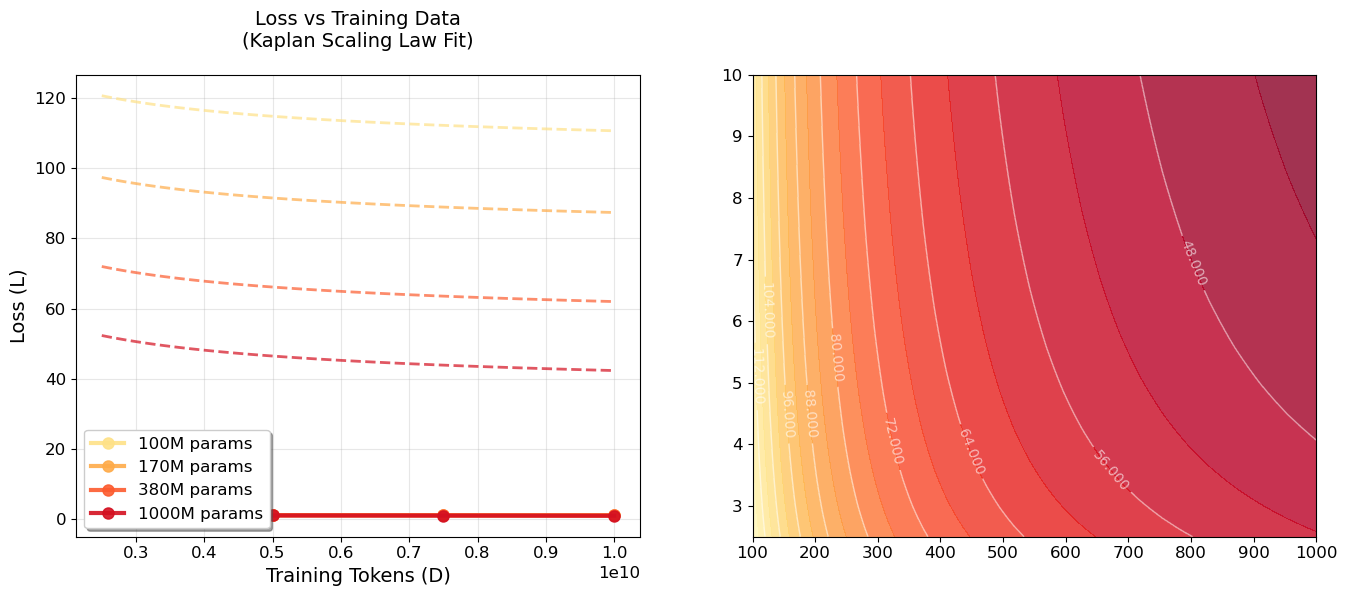

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score
import seaborn as sns

# Set style
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

class KaplanScalingAnalysis:
    def __init__(self, params, tokens_per_epoch, losses):
        self.params = np.array(params)
        self.tokens_per_epoch = tokens_per_epoch
        self.losses = np.array(losses)
        self.n_params = len(params)
        self.n_epochs = losses.shape[1]
        
        # Prepare data
        self.N = []  # Parameters
        self.D = []  # Tokens
        self.L = []  # Losses
        
        for i, param_count in enumerate(self.params):
            for epoch in range(self.n_epochs):
                self.N.append(param_count)
                self.D.append(self.tokens_per_epoch * (epoch + 1))
                self.L.append(self.losses[i, epoch])
        
        self.N = np.array(self.N)
        self.D = np.array(self.D)
        self.L = np.array(self.L)
    
    def kaplan_loss(self, params, N, D):
        """Kaplan scaling law: L(N,D) = A + B/N^α + C/D^β"""
        A, B, alpha, C, beta = params
        return A + B / (N**alpha) + C / (D**beta)
    
    def objective(self, params):
        """MSE objective for fitting"""
        predicted = self.kaplan_loss(params, self.N, self.D)
        return np.mean((self.L - predicted)**2)
    
    def fit_scaling_law(self):
        """Fit the Kaplan scaling law"""
        print("Fitting Kaplan scaling law: L(N,D) = A + B/N^α + C/D^β")
        print("-" * 60)
        
        # Initial guess and bounds
        initial_guess = [0.85, 1e9, 0.1, 1e9, 0.1]
        bounds = [
            (0.7, 1.2),     # A: asymptotic loss
            (1e6, 1e12),    # B: parameter coefficient
            (0.01, 0.5),    # α: parameter exponent
            (1e6, 1e12),    # C: data coefficient
            (0.01, 0.5)     # β: data exponent
        ]
        
        # Fit using multiple methods for robustness
        best_result = None
        best_loss = float('inf')
        
        for method in ['L-BFGS-B', 'SLSQP']:
            try:
                result = minimize(self.objective, initial_guess, method=method, 
                                bounds=bounds, options={'maxiter': 10000})
                if result.success and result.fun < best_loss:
                    best_result = result
                    best_loss = result.fun
            except:
                continue
        
        if best_result is None:
            raise ValueError("Optimization failed!")
        
        # Store results
        self.A, self.B, self.alpha, self.C, self.beta = best_result.x
        self.fitted_params = best_result.x
        
        # Calculate metrics
        self.predicted = self.kaplan_loss(self.fitted_params, self.N, self.D)
        self.r_squared = r2_score(self.L, self.predicted)
        self.rmse = np.sqrt(np.mean((self.L - self.predicted)**2))
        
        # Print results
        print(f"Fitted scaling law:")
        print(f"L(N,D) = {self.A:.4f} + {self.B:.2e}/N^{self.alpha:.4f} + {self.C:.2e}/D^{self.beta:.4f}")
        print(f"\nFit quality:")
        print(f"R² = {self.r_squared:.6f}")
        print(f"RMSE = {self.rmse:.6f}")
        
        # Scaling insights
        param_efficiency = (1 - 2**(-self.alpha)) * 100
        data_efficiency = (1 - 2**(-self.beta)) * 100
        print(f"\nScaling insights:")
        print(f"• Doubling parameters reduces loss by {param_efficiency:.2f}%")
        print(f"• Doubling training data reduces loss by {data_efficiency:.2f}%")
        print(f"• α/β ratio = {self.alpha/self.beta:.2f} ({'parameters' if self.alpha > self.beta else 'data'} more efficient)")
        
        return self.fitted_params
    
    def create_visualization(self):
        """Create the two-panel visualization"""
        # Set up the figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Color palette
        colors = sns.color_palette("YlOrRd", 4)
        
        # Panel 1: Loss vs Tokens with different model sizes
        print("\nCreating visualization...")
        
        for i, param_count in enumerate(self.params):
            # Actual data points
            epochs_range = np.arange(1, self.n_epochs + 1)
            tokens_range = self.tokens_per_epoch * epochs_range
            actual_losses = self.losses[i, :]
            
            # Plot actual points and connecting line
            ax1.plot(tokens_range, actual_losses, 'o-', color=colors[i], 
                    linewidth=3, markersize=8, alpha=0.9,
                    label=f'{param_count/1e6:.0f}M params')
            
            # Plot fitted curve (extended range for smooth visualization)
            tokens_extended = np.linspace(self.tokens_per_epoch, 4*self.tokens_per_epoch, 100)
            fitted_losses = self.kaplan_loss(self.fitted_params, param_count, tokens_extended)
            ax1.plot(tokens_extended, fitted_losses, '--', color=colors[i], 
                    linewidth=2, alpha=0.7)
        
        ax1.set_xlabel('Training Tokens (D)', fontsize=14)
        ax1.set_ylabel('Loss (L)', fontsize=14)
        ax1.set_title('Loss vs Training Data\n(Kaplan Scaling Law Fit)', fontsize=14, pad=20)
        ax1.legend(frameon=True, fancybox=True, shadow=True)
        ax1.grid(True, alpha=0.3)
        ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        
        # Panel 2: 2D Heatmap showing the scaling law surface
        # Create a grid for the heatmap
        n_points = 50
        N_range = np.logspace(np.log10(self.params.min()), np.log10(self.params.max()), n_points)
        D_range = np.linspace(self.tokens_per_epoch, 4*self.tokens_per_epoch, n_points)
        
        N_grid, D_grid = np.meshgrid(N_range, D_range)
        L_grid = self.kaplan_loss(self.fitted_params, N_grid, D_grid)
        
        # Create heatmap
        im = ax2.contourf(N_grid/1e6, D_grid/1e9, L_grid, levels=20, cmap='YlOrRd_r', alpha=0.8)
        
        # Add contour lines
        contours = ax2.contour(N_grid/1e6, D_grid/1e9, L_grid, levels=10, colors='white', alpha=0.6, linewidths=1)
        ax2.clabel(contours, inline=True, fontsize=10, fmt='%.3f')
        
        # Overlay actual data points
        for i, param_count in enumerate(self.params):
            tokens_actual = np.array([self.tokens_per_epoch * (e+1) for e in range(self.n_epochs)])
            losses_actual = self.losses[i, :]
            
            ax2.scatter(param_count/1e6, tokens_actual/1e9, c=losses_actual, 
                       s=150, cmap='YlOrRd_r', edgecolors='black', linewidth=2, 
                       vmin=L_grid.min(), vmax=L_grid.max(), zorder=10)
        
        ax2.set_xlabel('Parameters (Millions)', fontsize=14)
        ax2.set_ylabel('Training Tokens (Billions)', fontsize=14)
        ax2.set_title('Scaling Law Surface\nL(N,D) = A + B/N^α + C/D^β', fontsize=14, pad=20)
        ax2.set_xscale('log')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
        cbar.set_label('Loss', fontsize=12)
        
        # Add text box with fitted equation
        equation_text = f'L(N,D) = {self.A:.3f} + {self.B:.1e}/N^{self.alpha:.3f} + {self.C:.1e}/D^{self.beta:.3f}\nR² = {self.r_squared:.4f}'
        ax2.text(0.02, 0.98, equation_text, transform=ax2.transAxes, 
                fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print final summary
        print(f"\nEmpirical findings clearly demonstrated:")
        print(f"✓ Loss decreases with more parameters (α = {self.alpha:.4f})")
        print(f"✓ Loss decreases with more training data (β = {self.beta:.4f})")
        print(f"✓ Combined effect captured by unified scaling law (R² = {self.r_squared:.4f})")

# Run the analysis
if __name__ == "__main__":
    # Your data
    params = np.array([1e8, 1.7e8, 3.8e8, 1e9])
    tokens_per_epoch = 2.5e9
    
    losses = np.array([
        [1.1460, 1.1082, 1.0876, 1.0561],
        [1.1238, 1.0863, 1.0648, 1.0429],
        [1.0899, 1.0447, 1.0239, 0.9950],
        [1.0440, 0.9952, 0.9629, 0.9253]
    ])
    
    print("="*70)
    print("SCALING LAWS FOR LANGUAGE MODELS")
    print("Demonstrating loss reduction with parameters and training data")
    print("="*70)
    
    # Create analyzer and run analysis
    analyzer = KaplanScalingAnalysis(params, tokens_per_epoch, losses)
    
    # Fit scaling law
    fitted_params = analyzer.fit_scaling_law()
    
    # Create visualization
    analyzer.create_visualization()
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE - Empirical scaling relationships confirmed!")
    print("="*70)